# Objective
* 20190208: 
    * Given prices for the last N days, we do prediction for the next N+H days, where H is the forecast horizon
    * Here we use last value to do prediction

In [69]:
%matplotlib inline

import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

#### Input params ##################
stk_path = "./data/VTI_20130102_20181231.csv"
H_list = [1, 21, 42, 63]        # Forecast horizon we will be testing, in days. Note there are about 252 trading days in a year
train_size = 252*3              # Use 3 years of data as train set. Note there are about 252 trading days in a year
val_size = 252                  # Use 1 year of data as validation set

fontsize = 14
ticklabelsize = 14
####################################

train_val_size = train_size + val_size # Size of train+validation set
print("No. of days in train+validation set = " + str(train_val_size))

No. of days in train+validation set = 1008


In [70]:
print("We will start forecasting on day %d" % (train_val_size+1))

We will start forecasting on day 1009


# Common functions

In [71]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

def get_preds_last_val(data, H):
    """
    Given a series data, use its last value to forecast for the next H timesteps
    """
    return np.array([data[-1]]*H)
    

# Load data

In [72]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,date,open,high,low,close,adj_close,volume
0,2013-01-02,74.529999,75.150002,74.500000,75.139999,66.997757,5037200
1,2013-01-03,75.120003,75.370003,74.839996,75.029999,66.899689,2634600
2,2013-01-04,75.139999,75.519997,74.989998,75.410004,67.238510,2512900
3,2013-01-07,75.180000,75.279999,74.949997,75.209999,67.060173,2511200
4,2013-01-08,75.110001,75.180000,74.699997,75.010002,66.881859,1407900
5,2013-01-09,75.190002,75.410004,75.110001,75.239998,67.086937,1421900
6,2013-01-10,75.620003,75.769997,75.220001,75.760002,67.550591,1403700
7,2013-01-11,75.760002,75.800003,75.510002,75.769997,67.559486,1248500
8,2013-01-14,75.750000,75.800003,75.440002,75.690002,67.488159,2745100
9,2013-01-15,75.400002,75.889999,75.339996,75.830002,67.612984,1109100


In [73]:
df['date'].min(), df['date'].max() 

(Timestamp('2013-01-02 00:00:00'), Timestamp('2018-12-28 00:00:00'))

Text(0, 0.5, 'USD')

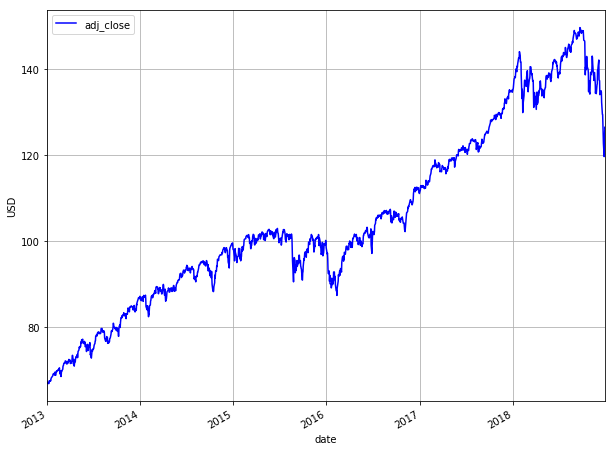

In [74]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Predict using Last Value, for a specific H and a specific date

In [75]:
i = train_val_size # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
H = 21 # We will test with this value of H and observe the results
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df.iloc[i]['date'], H))

Predicting on day 1008, date 2017-01-03 00:00:00, with forecast horizon H = 21


In [76]:
# Run prediction
preds_list = get_preds_last_val(df['adj_close'][i-train_val_size:i].values, H)

In [77]:
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df[i:i+H]['adj_close'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df[i:i+H]['adj_close'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df[i:i+H]['adj_close'], preds_list)))

For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the RMSE is 1.881956
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAPE is 1.590542
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAE is 1.798523


(736269.0, 736388.0)

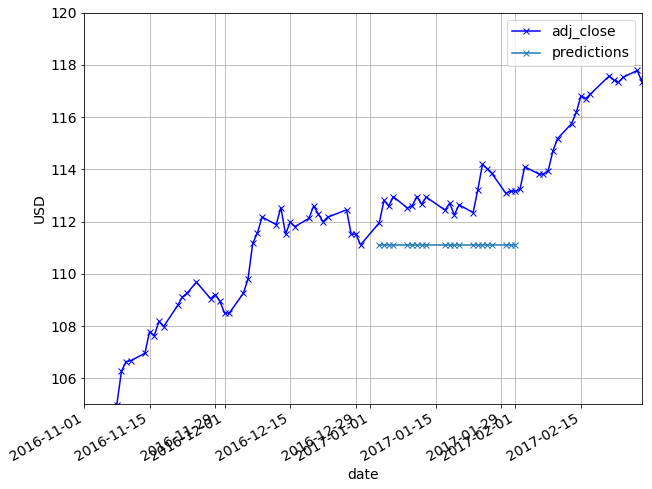

In [78]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([105, 120])
ax.set_xlim([date(2016, 11, 1), date(2017, 2, 28)])

# Predict using Last Value, for a specific H (forecast horizon)

In [79]:
rmse = [] # root mean square error
mape = [] # mean absolute percentage error
mae = []  # mean absolute error
preds_dict = {}
H = 21 # We will test with this value of H and observe the results
i_list = range(train_val_size, len(df)-21, 42)
for i in i_list:
# for i in tqdm_notebook(range(train_val_size, len(df)-H, int(H/2))): # Do a forecast on day i
    print("Predicting on day %d, date %s" % (i, df['date'][i]))
    preds_list = get_preds_last_val(df['adj_close'][i-train_val_size:i].values, H)
    
    # Collect the predictions
    preds_dict[i] = preds_list
    
    # Compute error metrics
    rmse.append(get_rmse(df[i:i+H]['adj_close'], preds_list))
    mape.append(get_mape(df[i:i+H]['adj_close'], preds_list))
    mae.append(get_mae(df[i:i+H]['adj_close'], preds_list))

print("Altogether we made %d forecasts, each of length %d days" % (len(rmse), H))

Predicting on day 1008, date 2017-01-03 00:00:00
Predicting on day 1050, date 2017-03-06 00:00:00
Predicting on day 1092, date 2017-05-04 00:00:00
Predicting on day 1134, date 2017-07-05 00:00:00
Predicting on day 1176, date 2017-09-01 00:00:00
Predicting on day 1218, date 2017-11-01 00:00:00
Predicting on day 1260, date 2018-01-03 00:00:00
Predicting on day 1302, date 2018-03-06 00:00:00
Predicting on day 1344, date 2018-05-04 00:00:00
Predicting on day 1386, date 2018-07-05 00:00:00
Predicting on day 1428, date 2018-09-04 00:00:00
Predicting on day 1470, date 2018-11-01 00:00:00
Altogether we made 12 forecasts, each of length 21 days


In [80]:
print("For forecast horizon %d, the mean RMSE is %f" % (H, np.mean(rmse)))
print("For forecast horizon %d, the mean MAPE is %f" % (H, np.mean(mape)))
print("For forecast horizon %d, the mean MAE is %f" % (H, np.mean(mae)))

For forecast horizon 21, the mean RMSE is 2.530277
For forecast horizon 21, the mean MAPE is 1.687632
For forecast horizon 21, the mean MAE is 2.258486


In [81]:
results = pd.DataFrame({'day': i_list,
                        'rmse': rmse,
                        'mape': mape,
                        'mae': mae})
results

,day,rmse,mape,mae
0,1008,1.881956,1.590542,1.798523
1,1050,1.222662,0.887714,1.037067
2,1092,1.129578,0.768410,0.919908
3,1134,1.742926,1.244739,1.533453
4,1176,1.814858,1.264953,1.587184
5,1218,1.464277,0.779692,1.023461
6,1260,5.278566,3.405527,4.815269
7,1302,3.353364,2.037145,2.737625
8,1344,4.837985,3.379564,4.676711
9,1386,4.414628,2.982431,4.279071


Text(0, 0.5, 'USD')

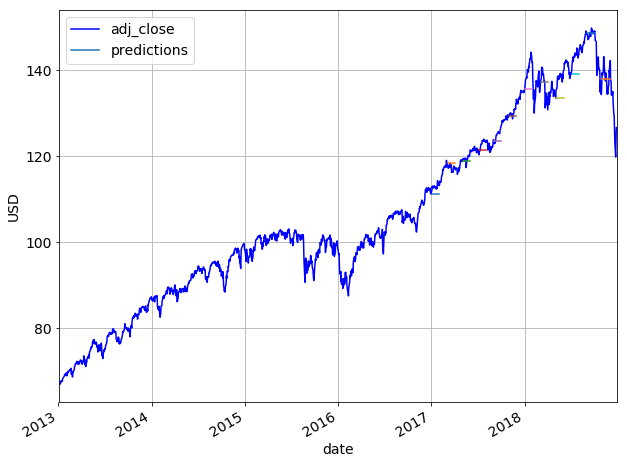

In [82]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)

# Plot the predictions
for key in preds_dict:
    ax.plot(df['date'][key:key+H], preds_dict[key])

ax.legend(['adj_close', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

(736330.0, 737059.0)

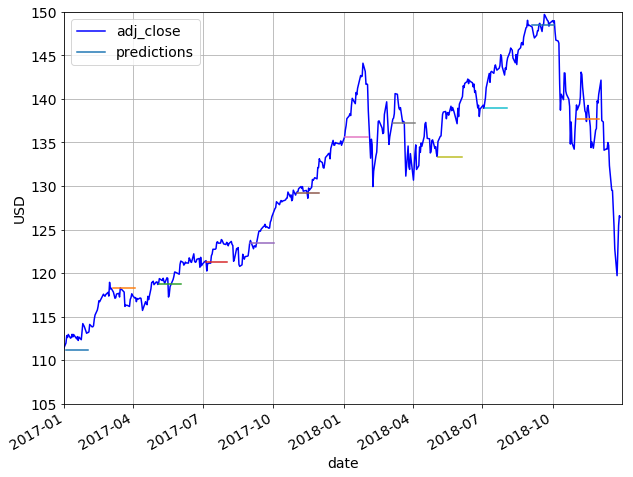

In [83]:
# Plot the predictions, and zoom in
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)

# Plot the predictions
for key in preds_dict:
    ax.plot(df['date'][key:key+H], preds_dict[key])
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([105, 150])
ax.set_xlim([date(2017, 1, 1), date(2018, 12, 31)])

# Predict using Last Value, for various H (forecast horizon)

In [84]:
rmse_list = [] # rmse for each H in H_list
mape_list = [] # mape for each H in H_list
mae_list = []  # mae for each H in H_list

for H in tqdm_notebook(H_list):
    rmse = [] # root mean square error
    mape = [] # mean absolute percentage error
    mae = []  # mean absolute error

    for i in tqdm_notebook(range(train_val_size, len(df)-H, max(1, int(H/2)))): # Do a forecast on day i
        preds_list = get_preds_last_val(df['adj_close'][i-train_val_size:i].values, H)
    
        # Compute error metrics
        rmse.append(get_rmse(df[i:i+H]['adj_close'], preds_list))
        mape.append(get_mape(df[i:i+H]['adj_close'], preds_list))
        mae.append(get_mae(df[i:i+H]['adj_close'], preds_list))
        
    rmse_list.append(np.mean(rmse))
    mape_list.append(np.mean(mape))
    mae_list.append(np.mean(mae))
    

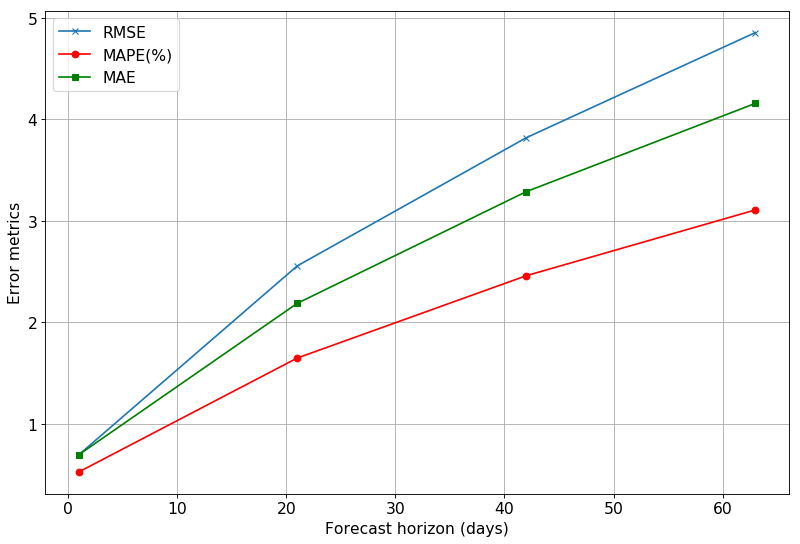

In [85]:
# Plot the error metrics for various forecast horizons
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(H_list, rmse_list, 'x-')
plt.plot(H_list, mape_list, 'ro-')
plt.plot(H_list, mae_list, 'gs-')
plt.xlabel('Forecast horizon (days)')
plt.ylabel('Error metrics')
plt.legend(['RMSE', 'MAPE(%)', 'MAE'], loc = 'upper left')
plt.grid()

matplotlib.rcParams.update({'font.size': 14})

# Findings
* The larger the forecast horizon, the larger the error
* Lowest RMSE, MAPE and MAE is achieved at forecast horizon H = 1